# Import Libraries

In [2]:
# run at the beginning -> restart kernel (right click mouse -> Restart kernel) -> Run all

!pip uninstall scikit-learn --yes
!pip install scikit-learn==1.5.2



Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 80.7 MB/s eta 0:00:00:00:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [3]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.5.2.


In [4]:
!rm -rf /kaggle/working/*

In [5]:
import os

dataset_dir = '/kaggle/input/cardiovascular-disease/cardio_data_processed.csv'

if os.path.exists(dataset_dir):
    print(f"{dataset_dir!r} exists ✅")
else:
    print(f"{dataset_dir!r} does NOT exist ❌")

import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))


'/kaggle/input/cardiovascular-disease/cardio_data_processed.csv' exists ✅
The scikit-learn version is 1.5.2.


In [6]:
!pip install skimpy
!pip install pingouin 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 81.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 43.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: polars
    Found existing installation: polars 1.9.0
    Uninstalling polars-1.9.0:
      Successfully uninstalled polars-1.9.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 6.17.1
    Uninstalling ipykernel-6.17.1:
      Successfully uninstalled ipykernel-6.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mkl-umath 0.1.1

In [7]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np

import os
import sys
import json
import time

# Visualization libs
import seaborn as sns
from skimpy import skim
import matplotlib.pyplot as plt

# Stats libs
import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Counter
from collections import Counter

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, stddev
from pyspark.ml.feature import VectorAssembler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel, RFE
import xgboost as xgb
import joblib
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

# Check for GPU-accelerated SMOTE
try:
    from cuml.sampling import SMOTE as GPU_SMOTE
    GPU_AVAILABLE = True
except ImportError:
    GPU_AVAILABLE = False

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Create output directories
os.makedirs('models_improved', exist_ok=True)
os.makedirs('plots', exist_ok=True)

print('Import packages successfully')

Import packages successfully


# Set dataset path and read it

In [8]:
data_path = '/kaggle/input/cardiovascular-disease/cardio_data_processed.csv'
data_visualization = pd.read_csv(data_path)

# Visualization sample dataset

In [9]:
display(data_visualization.head())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category,bp_category_encoded
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,Hypertension Stage 1,Hypertension Stage 1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,Hypertension Stage 2,Hypertension Stage 2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,Hypertension Stage 1,Hypertension Stage 1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,Hypertension Stage 2,Hypertension Stage 2
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,Normal,Normal


# Visualization data description

In [10]:
data_visualization.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
count,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000
mean,49972.410498,19462.667737,1.348625,164.372861,74.100688,126.434924,81.263925,1.363243,1.225174,0.087662,0.053134,0.803548,0.493688,52.823635,27.510513
std,28852.138290,2468.381854,0.476539,8.176756,14.288862,15.961685,9.143985,0.678080,0.571288,0.282805,0.224302,0.397317,0.499964,6.769909,6.026497
min,0.000000,10798.000000,1.000000,55.000000,11.000000,90.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.000000,3.471784
25%,24991.000000,17656.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000,23.875115
50%,50008.000000,19700.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000,26.346494
75%,74878.000000,21323.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000,30.116213
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,180.000000,120.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000,298.666667


# Visualization: Data information


In [11]:
data_visualization.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68205 entries, 0 to 68204
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   68205 non-null  int64  
 1   age                  68205 non-null  int64  
 2   gender               68205 non-null  int64  
 3   height               68205 non-null  int64  
 4   weight               68205 non-null  float64
 5   ap_hi                68205 non-null  int64  
 6   ap_lo                68205 non-null  int64  
 7   cholesterol          68205 non-null  int64  
 8   gluc                 68205 non-null  int64  
 9   smoke                68205 non-null  int64  
 10  alco                 68205 non-null  int64  
 11  active               68205 non-null  int64  
 12  cardio               68205 non-null  int64  
 13  age_years            68205 non-null  int64  
 14  bmi                  68205 non-null  float64
 15  bp_category          68205 non-null 

# Visualization: skimpy summary

In [12]:
skim(data_visualization)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 68205  │ │ int64       │ 13    │                                                          │
│ │ Number of columns │ 17     │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column         ┃ NA  ┃ NA %  ┃ mean      ┃ sd       ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ id             │   0 │     0 │     49970 │    28850 │      0 │  24990 │  50010 │  74880 │  100000 │ ██████ │  │
│ │ age            │   0 │     0 │     19460 │     2468 │  10800 │  17660 │  19700 │  21320 │   23710 │  ▁▄▆█▆ │  │
│ │ gender         │   0 │     0 │     1.349 │   0.4765 │      1 │      1 │      1 │      2 │       2 │ █    ▄ │  │
│ │ height         │   0 │     0 │     164.4 │    8.177 │     55 │    159 │    165 │    170 │     250 │    ▁█  │  │
│ │ weight         │   0 │     0 │      74.1 │    14.29 │     11 │     65 │     72 │     82 │     200 │   █▆   │  │
│ │ ap_hi          │   0 │     0 │     126.4 │    15.96 │     90 │    120 │    120 │    140 │     180 │ ▁▂█▂▂  │  │
│ │ ap_lo          │   0 │     0 │     81.26 │    9.144 │     60 │     80 │     80 │     90 │     120 │ ▁▂█▃▁  │  │
│ │ cholesterol    │   0 │     0 │     1.363 │   0.6781 │      1 │      1 │      1 │      1 │       3 │ █  ▁ ▁ │  │
│ │ gluc           │   0 │     0 │     1.225 │   0.5713 │      1 │      1 │      1 │      1 │       3 │ █  ▁ ▁ │  │
│ │ smoke          │   0 │     0 │   0.08766 │   0.2828 │      0 │      0 │      0 │      0 │       1 │ █    ▁ │  │
│ │ alco           │   0 │     0 │   0.05313 │   0.2243 │      0 │      0 │      0 │      0 │       1 │   █    │  │
│ │ active         │   0 │     0 │    0.8035 │   0.3973 │      0 │      1 │      1 │      1 │       1 │ ▂    █ │  │
│ │ cardio         │   0 │     0 │    0.4937 │      0.5 │      0 │      0 │      0 │      1 │       1 │ █    █ │  │
│ │ age_years      │   0 │     0 │     52.82 │     6.77 │     29 │     48 │     53 │     58 │      64 │  ▁▄▆█▆ │  │
│ │ bmi            │   0 │     0 │     27.51 │    6.026 │  3.472 │  23.88 │  26.35 │  30.12 │   298.7 │   █    │  │
│ └────────────────┴─────┴───────┴───────────┴──────────┴────────┴────────┴────────┴────────┴─────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃            ┃    ┃      ┃          ┃            ┃          ┃        ┃ chars per  ┃ words per   ┃ total      ┃  │
│ ┃ column     ┃ NA ┃ NA % ┃ shortest ┃ longest    ┃ min      ┃ max    ┃ row        ┃ row         ┃ words      ┃  │
│ ┡━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩  │
│ │ bp_categor │  0 │    0 │ Normal   │ Hypertensi │ Ele

# Define the mapping for bp_category

In [13]:
bp_mapping = {
    'Normal': 0,
    'Elevated': 1,
    'Hypertension Stage 1': 2,
    'Hypertension Stage 2': 3,
    'Hypertensive Crisis': 4
}

# Create a new numeric column
data_visualization['bp_category_numeric'] = data_visualization['bp_category'].map(bp_mapping)

# Define numeric columns (excluding original string columns)
numeric_columns = [
    'id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 
    'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 
    'age_years', 'bmi', 'bp_category_numeric'
]

# Set DataFrame for dataset

In [14]:
df_data = data_visualization[numeric_columns]

# Visualization: Target variable

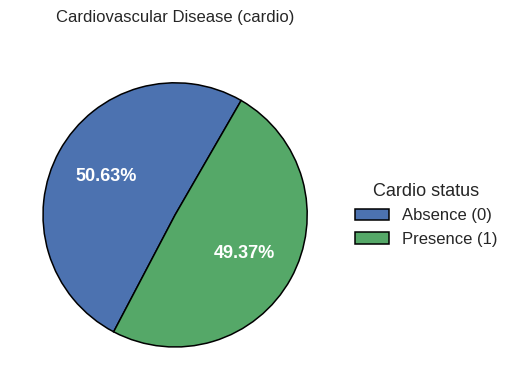

In [15]:
counts = Counter(data_visualization['cardio'])
sizes  = [counts[0], counts[1]]
labels = ['Absence (0)', 'Presence (1)']

fig, ax = plt.subplots(figsize=(6, 4))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=None,                # no labels on the wedges themselves
    autopct="%.2f%%",           # just show % inside
    pctdistance=0.6,            # controls label (“xx%”) position
    startangle=60,
    wedgeprops=dict(linewidth=1.1, edgecolor='black'),
    textprops=dict(color='white', fontsize=13, fontweight='bold')
)

ax.legend(
    wedges,                     # handles
    labels,                     # text labels
    title="Cardio status",
    loc="center left",          # anchor point for the legend
    bbox_to_anchor=(1, 0.5),    # (x, y) relative to the axes
    fontsize=12,
    title_fontsize=13
)

ax.set_title('Cardiovascular Disease (cardio)', pad=20)
plt.tight_layout()
plt.show()

# Visualization: Distribution of variables

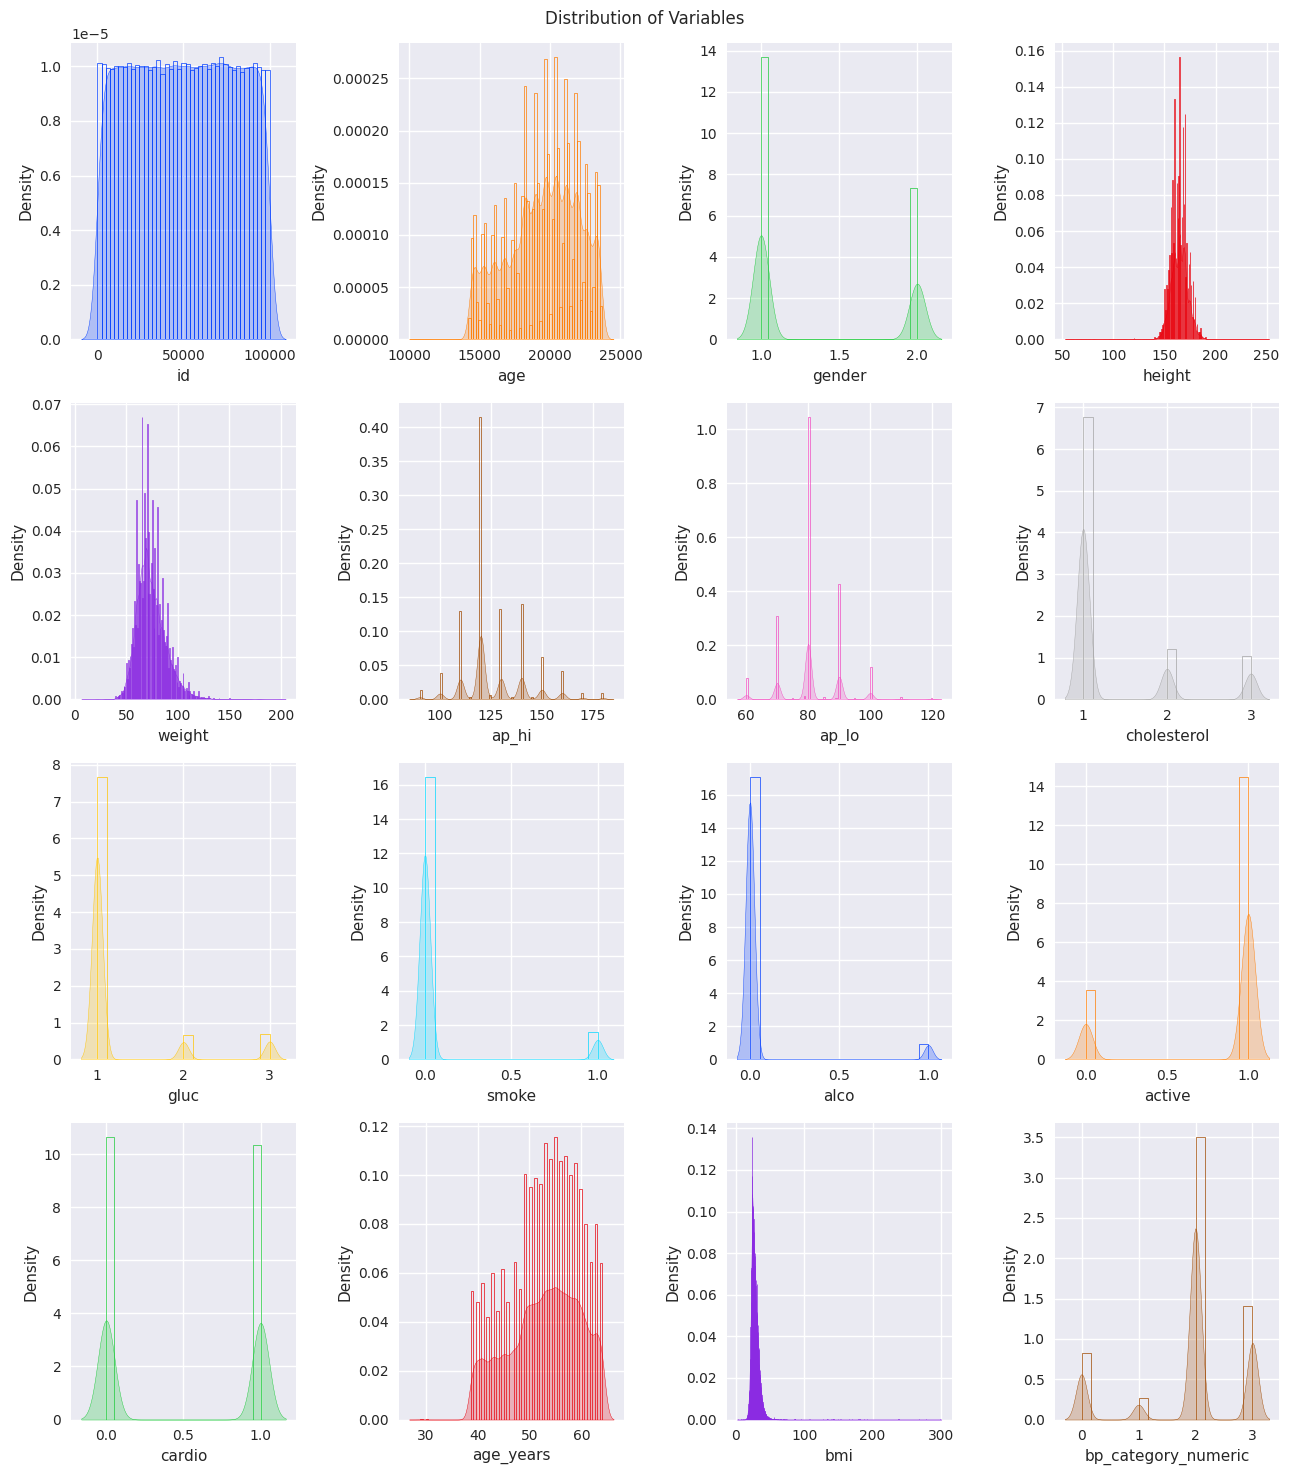

In [16]:
sns.set_style('darkgrid')
colors = sns.color_palette(palette='bright', n_colors=len(df_data.columns))
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(13,15))  # 4x4 for 16 columns
axs = axs.flat
for i, feature in enumerate(df_data.columns):
    sns.kdeplot(df_data, x=feature, fill=True, color=colors[i], ax=axs[i])
    sns.histplot(df_data, x=feature, stat='density', fill=False, color=colors[i], ax=axs[i])
fig.suptitle("Distribution of Variables")
fig.tight_layout()
plt.show()

# Visualization: Q-Q Plots

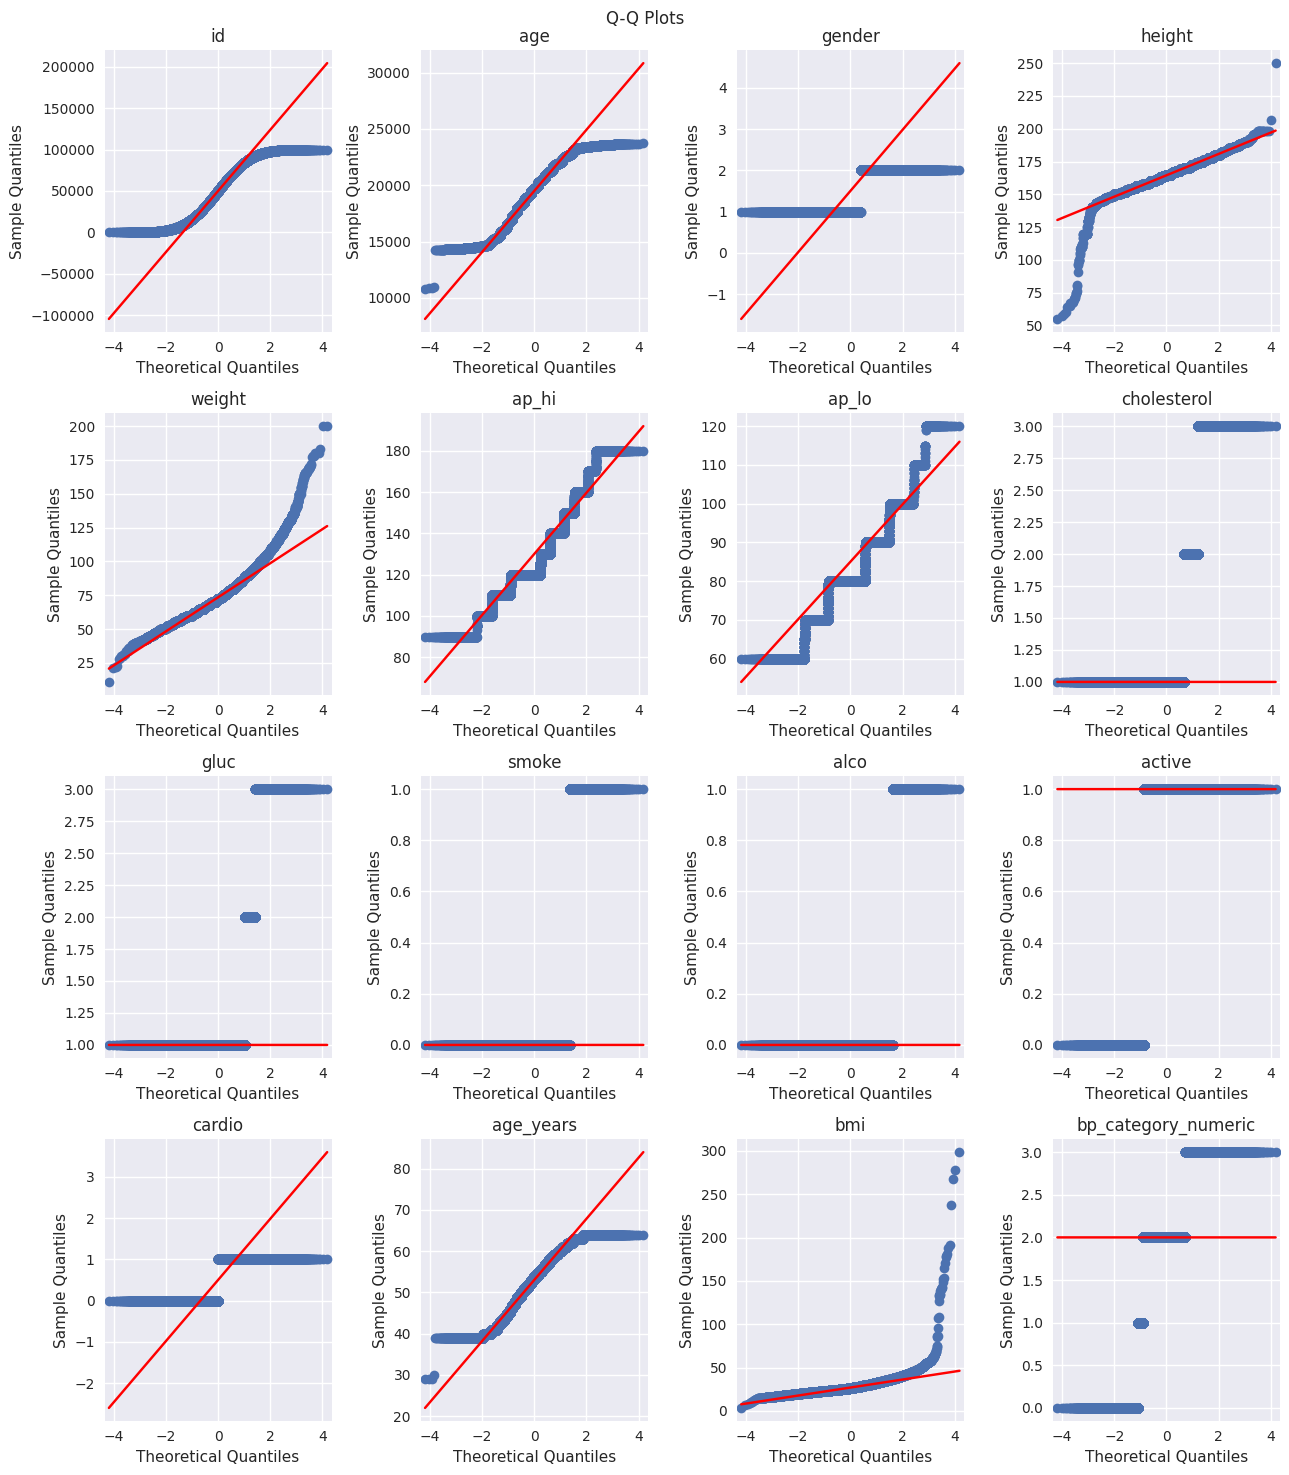

In [17]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(13,15))  # 4x4 for 16 columns
axs = axs.flat
for i, feature in enumerate(df_data.columns):
    sm.qqplot(df_data[feature], line='q', ax=axs[i], lw=2.1)
    axs[i].set_title(feature)
fig.suptitle("Q-Q Plots")
fig.tight_layout()
plt.show()

# Visualization: Training set correlation matrix

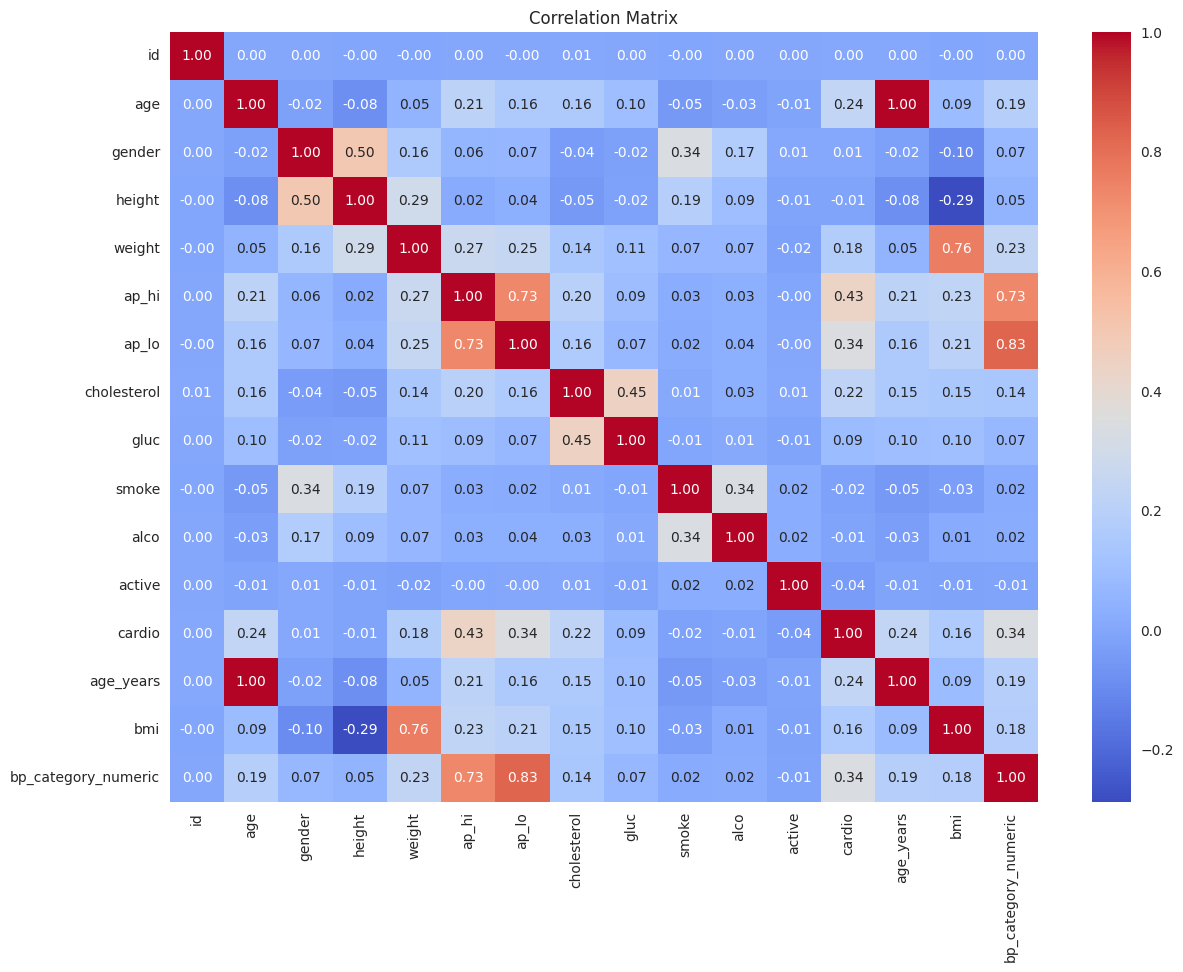

In [18]:
corr_matrix = df_data.corr()
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', ax=ax)
ax.set_title("Correlation Matrix")
plt.show()

# Define Spark Session Creation

In [ ]:
def create_spark_session(app_name="HeartDiseasePreprocessing"):
    """Create and return a Spark session."""
    if "JAVA_HOME" not in os.environ:
        os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
        print(f"Set JAVA_HOME to {os.environ['JAVA_HOME']}")
    
    os.environ["PYSPARK_PYTHON"] = sys.executable
    
    print("Initializing Spark session...")
    return SparkSession.builder \
        .appName(app_name) \
        .config("spark.driver.memory", "2g") \
        .config("spark.executor.memory", "2g") \
        .config("spark.rapids.sql.enabled", "true") \
        .master("local[*]") \
        .getOrCreate()

print("Define Spark Session Creation successfully")

Define Spark Session Creation successfully
Define Spark Session Creation successfully


# Define Data Preprocessing with Spark

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType

def preprocess_data(file_path):
    # Import all necessary modules at the beginning
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import col, when, udf
    from pyspark.sql.types import IntegerType, DoubleType, BooleanType
    from pyspark.ml.feature import VectorAssembler, StandardScaler
    from pyspark.ml.linalg import VectorUDT
    import numpy as np
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split
    import pandas as pd

    try:
        # Create Spark session
        spark = create_spark_session()
        spark.sparkContext.setLogLevel("ERROR")
        print("Successfully created Spark session")

        # Load data
        df = spark.read.csv(file_path, header=True, inferSchema=True)
        print(f"Loaded data with {df.count()} rows and {len(df.columns)} columns")

        # Display sample data
        sample_df = df.sample(fraction=0.01).toPandas()
        print("Sample of loaded data:")
        display(sample_df.head())

        # Define the base feature list as per your requirement
        feature_cols = [
            "age", "gender", "height", "weight", "ap_hi", "ap_lo",
            "cholesterol", "gluc", "smoke", "alco", "active",
            "age_years", "bmi"
        ]

        # Handle bp_category_encoded and append bp_category_numeric
        if 'bp_category_encoded' in df.columns:
            if df.schema['bp_category_encoded'].dataType.simpleString() == 'string':
                print("Converting bp_category_encoded from string to numeric")
                bp_category_mapping = {
                    'Normal': 0, 'Elevated': 1, 'Hypertension Stage 1': 2,
                    'Hypertension Stage 2': 3, 'Hypertensive Crisis': 4
                }
                map_udf = udf(lambda x: bp_category_mapping.get(x, -1), IntegerType())
                df = df.withColumn('bp_category_numeric', map_udf(col('bp_category_encoded')))
                df = df.drop('bp_category_encoded')
                feature_cols.append('bp_category_numeric')
            else:
                df = df.withColumnRenamed('bp_category_encoded', 'bp_category_numeric')
                feature_cols.append('bp_category_numeric')

        # Verify all features are present
        missing_features = [f for f in feature_cols if f not in df.columns]
        if missing_features:
            print(f"Warning: The following expected features are missing: {missing_features}")
        else:
            print(f"Using {len(feature_cols)} features: {', '.join(feature_cols)}")

        # Handle missing values in numeric columns
        numeric_cols = [field.name for field in df.schema.fields
                        if field.dataType.simpleString() in ['double', 'int', 'float']
                        and field.name in feature_cols]
        for col_name in numeric_cols:
            median_value = df.approxQuantile(col_name, [0.5], 0.001)[0]
            df = df.withColumn(col_name, when(col(col_name).isNull(), median_value).otherwise(col(col_name)))

        # Cast all feature columns to double
        for col_name in feature_cols:
            df = df.withColumn(col_name, col(col_name).cast("double"))

        # Assemble features into a vector
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled_features")
        assembled_df = assembler.transform(df)

        # Scale the features
        scaler = StandardScaler(inputCol="assembled_features", outputCol="features", withStd=True, withMean=True)
        scaler_model = scaler.fit(assembled_df)
        processed_df = scaler_model.transform(assembled_df)

        # Define UDF to filter NaN values in vectors
        def has_nan(vector):
            return any(np.isnan(v) for v in vector.toArray())
        has_nan_udf = udf(has_nan, BooleanType())
        processed_df = processed_df.filter(~has_nan_udf(col("features")))

        # Convert to Pandas for further processing
        pandas_processed = processed_df.select("features", "cardio").toPandas()
        X = np.array([x.toArray() for x in pandas_processed["features"]])
        y = pandas_processed["cardio"].values

        # Apply SMOTE for class balancing
        print("Applying SMOTE for class balancing...")
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_resampled, y_resampled, test_size=0.2, random_state=42
        )
        print(f"Split data into training ({len(X_train)} samples) and testing ({len(X_test)} samples)")

        # Stop Spark session
        spark.stop()
        print("Spark session stopped")

        # Return preprocessed data and feature columns
        return X_train, X_test, y_train, y_test, feature_cols

    except Exception as e:
        print(f"Error in preprocessing: {str(e)}")
        print("Falling back to pandas for preprocessing...")
        return preprocess_with_pandas(file_path)
print("Define Data Preprocessing with Spark")

# Cell 4: Define Pandas Fallback Preprocessing
Purpose: Define the preprocess_with_pandas fallback function with visualizations.

In [ ]:
def preprocess_with_pandas(file_path):
    df = pd.read_csv(file_path)
    
    df.fillna(df.median(numeric_only=True), inplace=True)
    
    feature_cols = [col for col in df.columns if col not in ['id', 'cardio', 'bp_category', 'bp_category_encoded']]
    
    X = df[feature_cols].values
    y = df['cardio'].values
    
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_scaled = (X - X_mean) / X_std
    
    # Visualization: Feature distribution after scaling
    plt.figure(figsize=(12, 6))
    for i in range(min(5, X_scaled.shape[1])):
        sns.histplot(X_scaled[:, i], label=f'Feature {i}', bins=30, alpha=0.5)
    plt.legend()
    plt.title("Distribution of Scaled Features (Pandas)")
    plt.show()
    
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
    
    # Visualization: Class distribution before and after SMOTE
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=y)
    plt.title("Class Distribution Before SMOTE (Pandas)")
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_resampled)
    plt.title("Class Distribution After SMOTE (Pandas)")
    plt.tight_layout()
    plt.show()
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42
    )
    print(f"Processed with pandas: {len(X_train)} training samples, {len(X_test)} testing samples")
    
    return X_train, X_test, y_train, y_test

print("Define Pandas Fallback Preprocessing")

# Preprocess Data
Purpose: Execute data preprocessing, calling the defined functions.

In [22]:
X_train, X_test, y_train, y_test, feature_cols = preprocess_data(data_path)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/20 08:53:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Successfully created Spark session


Loaded data with 68205 rows and 17 columns
Sample of loaded data:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category,bp_category_encoded
0,172,21865,1,152,67.0,160,90,1,1,0,0,0,1,59,28.999307,Hypertension Stage 2,Hypertension Stage 2
1,297,18839,1,158,70.0,120,80,1,1,0,0,1,1,51,28.040378,Hypertension Stage 1,Hypertension Stage 1
2,343,18220,1,142,61.0,120,80,1,1,0,0,1,0,49,30.251934,Hypertension Stage 1,Hypertension Stage 1
3,817,17420,2,175,88.0,140,90,2,1,1,1,0,1,47,28.734694,Hypertension Stage 2,Hypertension Stage 2
4,935,20339,2,160,66.0,120,80,1,1,0,0,1,0,55,25.781250,Hypertension Stage 1,Hypertension Stage 1


Converting bp_category_encoded from string to numeric
Using 14 features: age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, age_years, bmi, bp_category_numeric


Applying SMOTE for class balancing...
Split data into training (55252 samples) and testing (13814 samples)
Spark session stopped


# Define Feature Selection
Purpose: Define the perform_feature_selection function with its existing visualization.

In [23]:
def perform_feature_selection(X, y, features, method=None):
    print(f"Performing feature selection")
    
    selected_features = features
    model = RandomForestClassifier(random_state=RANDOM_STATE)
    model.fit(X, y)
    # feature_importance = pd.Series(model.feature_importances_, index=features)
    # plt.figure(figsize=(10, 6))
    # feature_importance.sort_values(ascending=False).plot(kind='bar')
    # plt.title('Feature Importance')
    # plt.xlabel('Features')
    # plt.ylabel('Importance')
    # plt.tight_layout()
    # plt.savefig('plots/feature_importance_all.png')
    # plt.show()

    if selected_features:
        selected_indices = [int(feat.split('_')[1]) for feat in selected_features]
        X = X[:, selected_indices]  # Use integer indices to subset NumPy array
        features = [features[i] for i in selected_indices]
    
    
    return selected_features

print("Perform feature selection successfully")

Perform feature selection successfully


# Execute Feature Selection
Purpose: Apply feature selection to the preprocessed data.

In [24]:
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

X_combined = np.vstack((X_train, X_test))
y_combined = np.concatenate((y_train, y_test))

selected_features = perform_feature_selection(X_combined, y_combined, feature_names, method=None)

print("Execute Feature Selection Successfully")

Performing feature selection
Execute Feature Selection Successfully


# Define Model Training and Evaluation

Purpose: Define the train_and_evaluate_models function with its rich set of visualizations.

In [25]:
def train_and_evaluate_models(X, y, features, selected_features):

    if selected_features:
        # Convert string feature names like 'feature_0' to integer indices
        selected_indices = [int(feat.split('_')[1]) for feat in selected_features]
        X = X[:, selected_indices]  # Use integer indices to subset NumPy array
        # Update features to corresponding names from the full list
        features = [features[i] for i in selected_indices]

    # Rest of the function remains unchanged
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"After SMOTE: {X_train_resampled.shape[0]} training samples")
    
    scaler = SklearnStandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    joblib.dump(scaler, 'models_improved/scaler.joblib')
    
    models = {
        'logistic_regression': {
            'model': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
            'params': {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
        },
        'random_forest': {
            'model': RandomForestClassifier(random_state=RANDOM_STATE),
            'params': {'n_estimators': [100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5], 'max_features': ['sqrt', 'log2']}
        },
        'gradient_boosting': {
            'model': GradientBoostingClassifier(random_state=RANDOM_STATE),
            'params': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
        },
        'xgboost': {
            'model': xgb.XGBClassifier(random_state=RANDOM_STATE),
            'params': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
        }
    }
    
    results = []
    best_models = {}
    
    for model_name, model_info in models.items():
        print(f"\nTraining {model_name}...")
        start_time = time.time()

        # Training Configuration for Logistic Regression Model
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_scaled, y_train_resampled)
        
        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model
        
        y_pred = best_model.predict(X_test_scaled)
        y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        
        # Visualization: Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Disease'])
        disp.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.savefig(f'plots/confusion_matrix_{model_name}.png')
        plt.show()
        
        training_time = time.time() - start_time
        model_result = {
            'model_name': model_name, 'accuracy': float(accuracy), 'precision': float(precision),
            'recall': float(recall), 'f1': float(f1), 'auc': float(auc), 'training_time': float(training_time),
            'best_params': best_model.get_params(), 'optimal_threshold': float(optimal_threshold)
        }
        results.append(model_result)
        
        print(f"{model_name} results:")
        print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
        
        joblib.dump(best_model, f'models_improved/best_model_{model_name}.joblib')
        calibrated_model = CalibratedClassifierCV(best_model, cv='prefit')
        calibrated_model.fit(X_train_scaled, y_train_resampled)
        joblib.dump(calibrated_model, f'models_improved/calibrated_model_{model_name}.joblib')
    
    # Ensemble Model
    print("\nCreating ensemble model...")
    estimators = [(name, model) for name, model in best_models.items()]
    ensemble = VotingClassifier(estimators=estimators, voting='soft')
    ensemble_start_time = time.time()
    ensemble.fit(X_train_scaled, y_train_resampled)
    ensemble_training_time = time.time() - ensemble_start_time
    
    y_pred_ensemble = ensemble.predict(X_test_scaled)
    y_prob_ensemble = ensemble.predict_proba(X_test_scaled)[:, 1]
    
    accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
    precision_ensemble = precision_score(y_test, y_pred_ensemble)
    recall_ensemble = recall_score(y_test, y_pred_ensemble)
    f1_ensemble = f1_score(y_test, y_pred_ensemble)
    auc_ensemble = roc_auc_score(y_test, y_prob_ensemble)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob_ensemble)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold_ensemble = thresholds[optimal_idx]
    
    # Visualization: Ensemble Confusion Matrix
    cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['No Disease', 'Disease'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix - Ensemble')
    plt.savefig('plots/confusion_matrix_ensemble.png')
    plt.show()
    
    ensemble_result = {
        'model_name': 'ensemble', 'accuracy': float(accuracy_ensemble), 'precision': float(precision_ensemble),
        'recall': float(recall_ensemble), 'f1': float(f1_ensemble), 'auc': float(auc_ensemble),
        'training_time': float(ensemble_training_time), 'optimal_threshold': float(optimal_threshold_ensemble)
    }
    results.append(ensemble_result)
    
    joblib.dump(ensemble, 'models_improved/ensemble_model.joblib')
    calibrated_ensemble = CalibratedClassifierCV(ensemble, cv='prefit')
    calibrated_ensemble.fit(X_train_scaled, y_train_resampled)
    joblib.dump(calibrated_ensemble, 'models_improved/calibrated_model_ensemble.joblib')
    
    with open('models_improved/feature_names.json', 'w') as f:
        json.dump(features, f)


    # Define the convert_numpy_types function to convert numpy types to Python native types for JSON serialization.
    def convert_numpy_types(obj):
        if isinstance(obj, (np.integer, np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert_numpy_types(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(i) for i in obj]
        else:
            return obj

    with open('models_improved/model_metrics.json', 'w') as f:
        json.dump(convert_numpy_types(results), f, indent=2)
    
    
    # Visualization: ROC Curves
    plt.figure(figsize=(10, 8))
    for result in results:
        model_name = result['model_name']
        model = ensemble if model_name == 'ensemble' else best_models[model_name]
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["auc"]:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.savefig('plots/roc_curves.png')
    plt.show()
    
    # Visualization: All Confusion Matrices
    plt.figure(figsize=(15, 10))
    model_names = list(best_models.keys()) + ['ensemble']
    rows = (len(model_names) + 1) // 2
    for i, model_name in enumerate(model_names):
        plt.subplot(rows, 2, i+1)
        model = ensemble if model_name == 'ensemble' else best_models[model_name]
        cm = confusion_matrix(y_test, model.predict(X_test_scaled))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Disease'])
        disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca(), colorbar=False)
        plt.title(f'{model_name}')
    plt.tight_layout()
    plt.savefig('plots/all_confusion_matrices.png')
    plt.show()
    
    # Additional Visualization: Metrics Comparison
    metrics_df = pd.DataFrame(results).set_index('model_name')[['accuracy', 'precision', 'recall', 'f1', 'auc']]
    plt.figure(figsize=(12, 6))
    sns.heatmap(metrics_df.T, annot=True, cmap='YlGnBu', fmt='.4f')
    plt.title("Model Performance Metrics")
    plt.show()
    
    return results, best_models, ensemble

print("Define Model Training and Evaluation successfully")

Define Model Training and Evaluation successfully


# Execute Model Training and Evaluation
Purpose: Run the training pipeline and display results.

After SMOTE: 55252 training samples

Training logistic_regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


<Figure size 800x600 with 0 Axes>

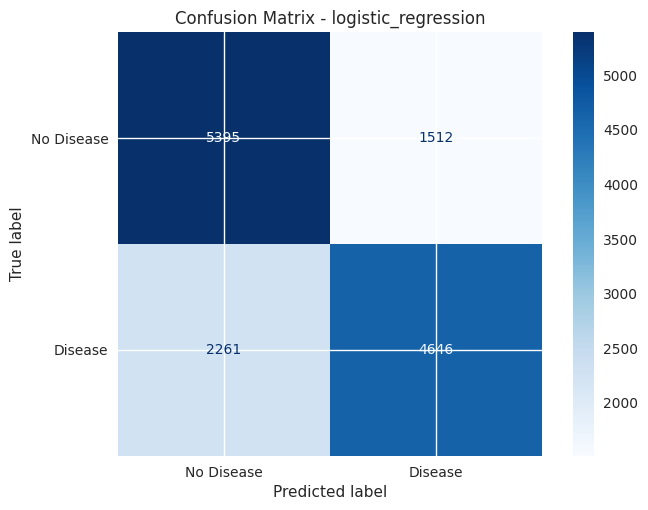

logistic_regression results:
  Accuracy: 0.7269, Precision: 0.7545, Recall: 0.6727, F1: 0.7112, AUC: 0.7884

Training random_forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


<Figure size 800x600 with 0 Axes>

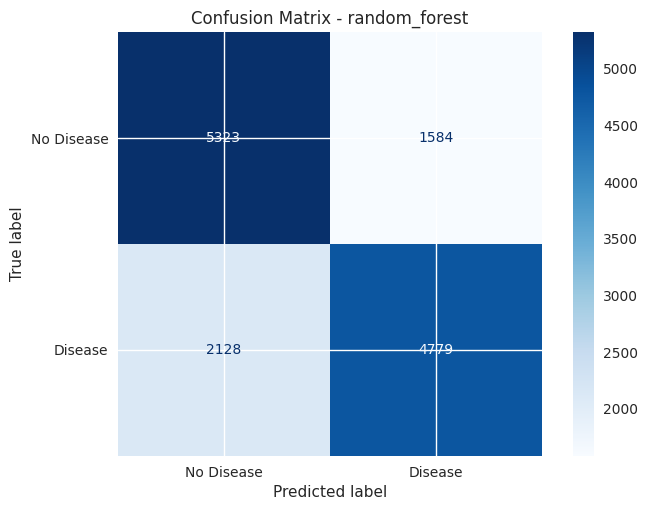

random_forest results:
  Accuracy: 0.7313, Precision: 0.7511, Recall: 0.6919, F1: 0.7203, AUC: 0.7988

Training gradient_boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


<Figure size 800x600 with 0 Axes>

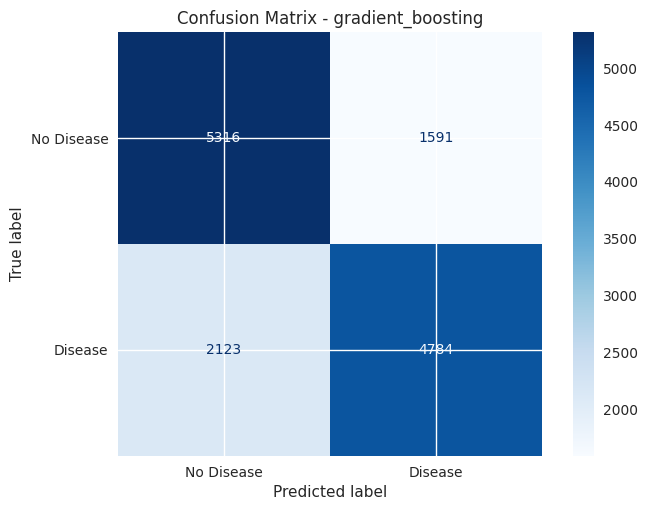

gradient_boosting results:
  Accuracy: 0.7311, Precision: 0.7504, Recall: 0.6926, F1: 0.7204, AUC: 0.7998

Training xgboost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


<Figure size 800x600 with 0 Axes>

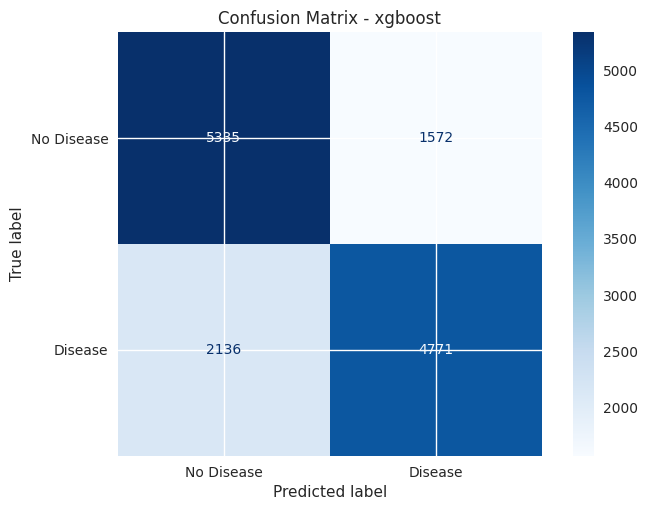

xgboost results:
  Accuracy: 0.7316, Precision: 0.7522, Recall: 0.6907, F1: 0.7202, AUC: 0.7997

Creating ensemble model...


<Figure size 800x600 with 0 Axes>

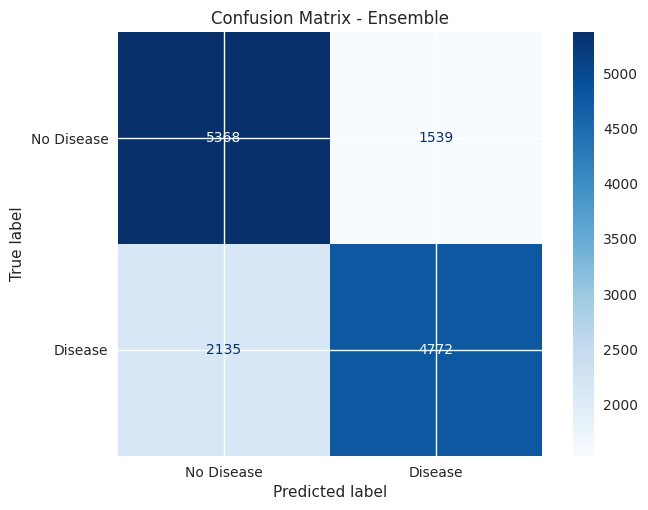

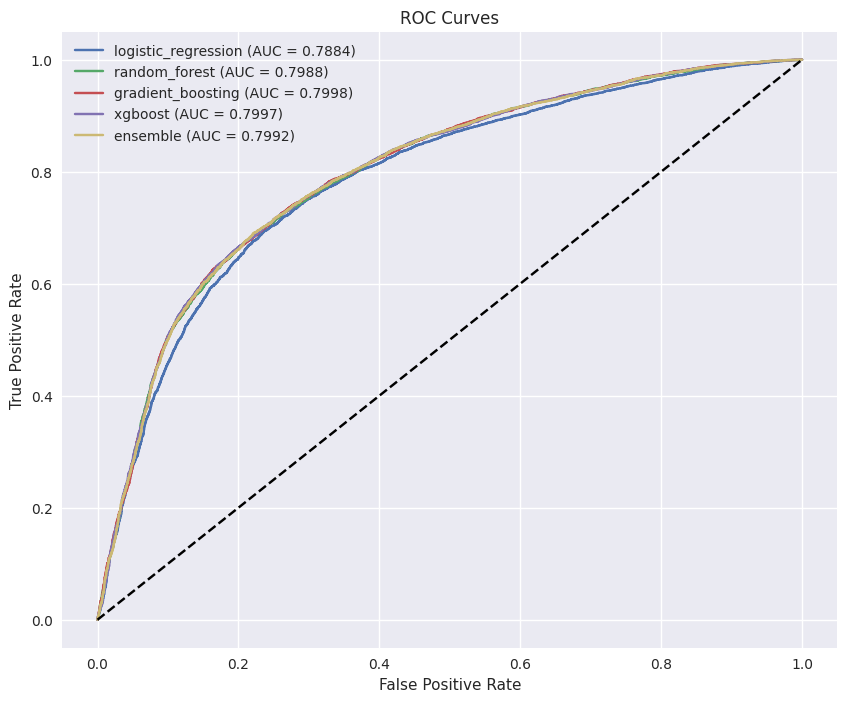

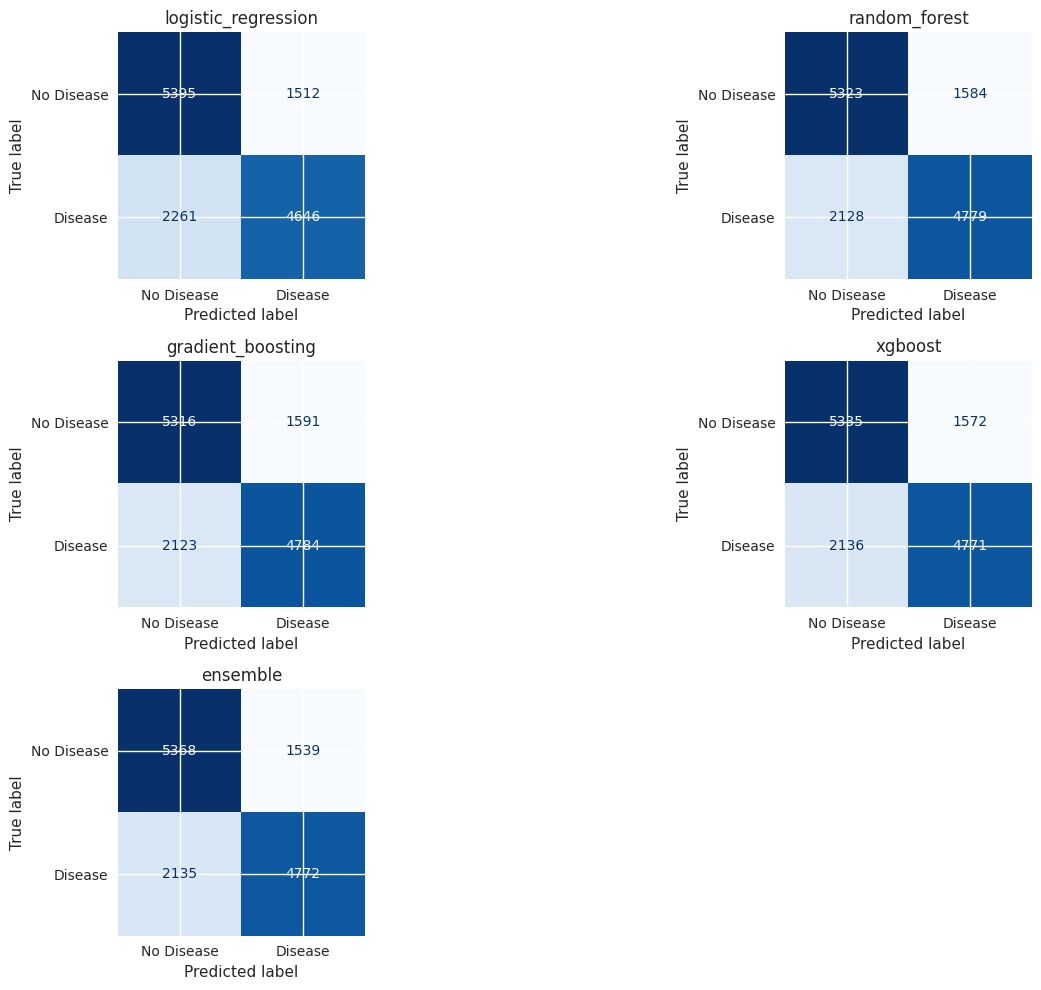

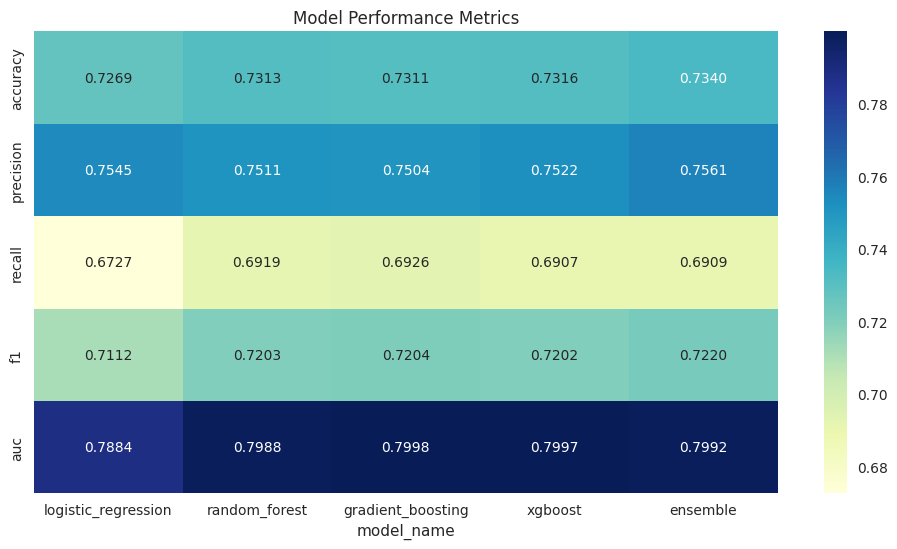

In [26]:
results, best_models, ensemble = train_and_evaluate_models(X_combined, y_combined, feature_names, selected_features)

# Display Final Results
Purpose: Summarize and visualize the best model.


Best model: gradient_boosting
  AUC: 0.7998
  Accuracy: 0.7311
  Precision: 0.7504
  Recall: 0.6926
  F1 Score: 0.7204


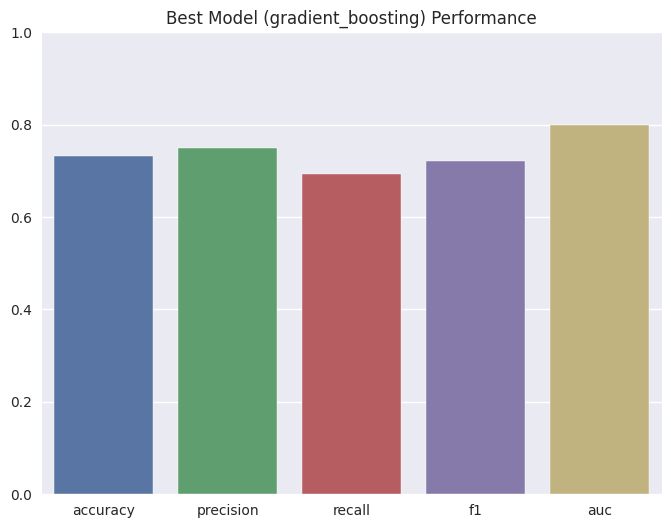

In [29]:
best_result = max(results, key=lambda x: x['auc'])
print(f"\nBest model: {best_result['model_name']}")
print(f"  AUC: {best_result['auc']:.4f}")
print(f"  Accuracy: {best_result['accuracy']:.4f}")
print(f"  Precision: {best_result['precision']:.4f}")
print(f"  Recall: {best_result['recall']:.4f}")
print(f"  F1 Score: {best_result['f1']:.4f}")

# Visualization: Bar plot of best model metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
values = [best_result[m] for m in metrics]
plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=values)
plt.title(f"Best Model ({best_result['model_name']}) Performance")
plt.ylim(0, 1)
plt.show()